## Neural Network Model

In [39]:
# Import Dependencies

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import sklearn as skl


In [40]:
# Import and read csv
heart_failure_df = pd.read_csv("/Users/siawashahmar/Desktop/Data Analytics Bootcamp/team2_project4/heart_failure_clinical_records_dataset.csv")
heart_failure_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


All columns will be used as features
No categorical data

In [41]:
# Split data into features and target arrays

y = heart_failure_df['DEATH_EVENT'].values
X = heart_failure_df.drop(['DEATH_EVENT'], axis='columns').values

# Split data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Scale Data

In [42]:
# Create a  StandardScaler Instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Auto Optimization 

In [43]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=12))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [44]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Reloading Tuner from ./untitled_project/tuner0.json


In [45]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [46]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 9,
 'num_layers': 3,
 'units_0': 5,
 'units_1': 3,
 'units_2': 5,
 'units_3': 1,
 'units_4': 1,
 'units_5': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0020'}

In [47]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 - 0s - 101ms/step - accuracy: 0.8133 - loss: 0.5097
Loss: 0.5096867084503174, Accuracy: 0.8133333325386047


### Manual Optimization: First Attempt

In [48]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=9, input_dim=input_feat, activation="tanh"))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=36, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="tanh"))

# Summary of model
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 9)              │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 36)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514 (2.01 KB)

 Trainable params: 514 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### Train Model

In [50]:
fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5900 - loss: 3.1556
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6653 - loss: 2.9722
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6706 - loss: 2.8860
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 2.3134
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6618 - loss: 2.3157
Epoch 6/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6835 - loss: 2.1488
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7145 - loss: 2.0393
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6976 - loss: 1.5126
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7414 - loss: 1.6357
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7303 - loss: 0.9952
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7070 - loss: 0.9068
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7487 - loss: 0.6304
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7145 - loss: 0.7475
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 0.8864
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7579 - loss: 0.6968
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7210 - loss: 0.7669
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7135 - loss: 0.5855
Epoch 18/50
7/7 ━━━

In [51]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 61ms/step - accuracy: 0.7867 - loss: 0.7833
Loss: 0.7832940220832825, Accurac: 0.7866666913032532


#### Second Attempt

In [52]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=input_feat, activation="relu"))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6867 - loss: 0.6312
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6642 - loss: 0.6131
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7568 - loss: 0.5211
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - loss: 0.5245
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.4514
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.4190
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8287 - loss: 0.4091
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.3939
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.3724
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.3443
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8351 - loss: 0.3925
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9017 - loss: 0.2946
Epoch 13/50
7

In [54]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 80ms/step - accuracy: 0.8400 - loss: 0.5401
Loss: 0.5400630235671997, Accurac: 0.8399999737739563


#### Thrid Attempt

In [55]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=input_feat, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4540 - loss: 0.7329
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7155 - loss: 0.6180
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7761 - loss: 0.5563
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7936 - loss: 0.5139
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.4834
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8341 - loss: 0.4359
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8155 - loss: 0.3935
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8580 - loss: 0.3890 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.3938
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8654 - loss: 0.3685
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.3475
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8787 - loss: 0.3298
Epoch 13/50


In [57]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 149ms/step - accuracy: 0.8133 - loss: 0.5301
Loss: 0.5300652980804443, Accurac: 0.8133333325386047


#### 4th Attempt

In [58]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=input_feat,  activation=tf.keras.layers.LeakyReLU(alpha=0.1)))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation='relu'))

# 3rd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,951 (62.31 KB)

 Trainable params: 15,951 (62.31 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6099 - loss: 0.6672
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7092 - loss: 0.5980
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 0.5817 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7319 - loss: 0.5032
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8017 - loss: 0.4419
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.4353
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8420 - loss: 0.3958
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8607 - loss: 0.3385
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8565 - loss: 0.3320
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8434 - loss: 0.3483
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.2970
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8817 - loss: 0.2855
Epoch 13/50


In [60]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 151ms/step - accuracy: 0.7600 - loss: 1.5107
Loss: 1.5106961727142334, Accurac: 0.7599999904632568


#### 5th Attempt

In [61]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=9, input_dim=input_feat, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=36, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 9)              │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 36)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514 (2.01 KB)

 Trainable params: 514 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[early_stopping]) 

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7050 - loss: 0.6285
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7218 - loss: 0.6276
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7465 - loss: 0.5846
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7639 - loss: 0.5503
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525 - loss: 0.5600
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7300 - loss: 0.5356
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7165 - loss: 0.5615
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7167 - loss: 0.5567
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7504 - loss: 0.5155
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.5094
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.4805
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - loss: 0.4752
E

In [63]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 92ms/step - accuracy: 0.8400 - loss: 0.4351
Loss: 0.4350535571575165, Accurac: 0.8399999737739563


### 6th Attempt

In [64]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=9, input_dim=input_feat, activation="tanh"))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=36, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 9)              │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 36)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514 (2.01 KB)

 Trainable params: 514 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[early_stopping]) 

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4631 - loss: 0.7095
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4991 - loss: 0.7015 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5990 - loss: 0.6732
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6672 - loss: 0.6431
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6722 - loss: 0.6320
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6960 - loss: 0.6197
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6965 - loss: 0.6156
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.5937
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7142 - loss: 0.5993
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7157 - loss: 0.5925
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.5673
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646 - loss: 0.5758


In [66]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 57ms/step - accuracy: 0.8267 - loss: 0.4469
Loss: 0.4468637704849243, Accurac: 0.8266666531562805


Increasing the number of hidden layers resulted in a decrease of accuracy and increase of loss >1; suggest model may be too complex for data

How to Address High Loss

    Normalize/Standardize Data: Rescale your inputs and outputs to a range that aligns with your model's activation functions and loss functions.

    Adjust the Model: Ensure the architecture is appropriate for the complexity of your data.

    Tune Hyperparameters: Experiment with learning rate, regularization, and optimizer settings.

    Inspect Data: Check for noisy, inconsistent, or outlier data.

Model Architecture Details

Input Layer Configuration

Input dimension matches feature count
First layer uses 50 neurons with LeakyReLU activation
Uses negative slope (alpha) of 0.1 for LeakyReLU


Hidden Layers

First hidden layer: 50 neurons with LeakyReLU
Second hidden layer: 100 neurons with ReLU
Output layer: Single neuron with sigmoid activation


Model Parameters

Total params: 5,851
Trainable params: 5,851



Training Performance

Used Early Stopping (patience=5)
Trained for 50 epochs
Accuracy progression:

Started around 51-52% in first epoch
Steadily improved to 96-97% in later epochs


Final training accuracy: 95.66%
Test set accuracy: 85.33%

Key Observations

Strong Performance

High training accuracy (95.66%)
Solid test accuracy (85.33%)
Smooth learning curve


Potential Overfitting Indicators

Large gap between training (95.66%) and test (85.33%) accuracy
Suggests model might be overfitting

### 7th Attempt

#### Prevent Overfitting

In [67]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, 
        input_dim=input_feat, 
        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
        kernel_regularizer=l2(0.001)  # Add L2 regularization
    ),
    tf.keras.layers.Dropout(0.3),  # Add dropout
    
    tf.keras.layers.Dense(100, 
        activation="relu",
        kernel_regularizer=l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])
nn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[early_stopping]) 

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3211 - loss: 0.9131
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5311 - loss: 0.7837
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6359 - loss: 0.7454
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6632 - loss: 0.7112
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.6530
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7617 - loss: 0.6014
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7504 - loss: 0.6299
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7191 - loss: 0.6187
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.5905
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7994 - loss: 0.5815
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.5631
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8214 - loss: 0.5238
E

In [69]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 63ms/step - accuracy: 0.8400 - loss: 0.5170
Loss: 0.5169656276702881, Accurac: 0.8399999737739563


#### 8th Attempt

#### Cross-Validation

In [70]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import clone_model

def create_model(input_feat):
    nn = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, 
            input_dim=input_feat, 
            activation=tf.keras.layers.LeakyReLU(alpha=0.1),
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(100, 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return nn

# Perform Cross-Validation
def cross_validate_model(X, y, input_feat):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_index, val_index in kfold.split(X, y):
        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Scale data (using the same scaler as before)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Create and train model
        model = create_model(input_feat)
        
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Fit model
        history = model.fit(
            X_train_scaled, y_train, 
            validation_data=(X_val_scaled, y_val),
            epochs=50, 
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0  # Suppress output
        )
        
        # Evaluate model
        val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
        cv_scores.append(val_accuracy)
    
    return cv_scores

# Perform cross-validation
input_feat = X_train.shape[1]
cv_results = cross_validate_model(X, y, input_feat)

print("Cross-validation scores:", cv_results)
print("Mean CV Score:", np.mean(cv_results))
print("Standard Deviation:", np.std(cv_results))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulari

Cross-validation scores: [0.7666666507720947, 0.8500000238418579, 0.8166666626930237, 0.8500000238418579, 0.7966101765632629]
Mean CV Score: 0.8159887075424195
Standard Deviation: 0.032006848151582785


#### Cross Validation Analysis
Consistent Performance:

    Scores Scores range from 76.67% to 86.67%
    Relatively low standard deviation (3.92%)
    Indicates model's stability across different data splits

Improvement Suggestions

    The 3.92% standard deviation suggests some variability
    Could potentially improve by:

        Collecting more data
        Feature engineering
        Trying ensemble methods

#### 9th Attempt - Address the warning

In [76]:
# Define input features
input_feat = X_train.shape[1]

# Create model with recommended input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_feat,)),
    tf.keras.layers.Dense(50, 
        activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(100, 
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Fit model
history = model.fit(
    X_train_scaled, y_train, 
    validation_split=0.2,
    epochs=50, 
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4347 - loss: 0.8347 - val_accuracy: 0.5778 - val_loss: 0.7675
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5526 - loss: 0.7780 - val_accuracy: 0.6667 - val_loss: 0.7307
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6476 - loss: 0.7279 - val_accuracy: 0.6444 - val_loss: 0.7127
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7019 - loss: 0.6778 - val_accuracy: 0.6444 - val_loss: 0.7031
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7351 - loss: 0.5986 - val_accuracy: 0.6222 - val_loss: 0.6965
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8482 - loss: 0.5495 - val_accuracy: 0.6222 - val_loss: 0.6917
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7715 - loss: 0.5741 - val_accuracy: 0.6222 - val_loss: 0.6869
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8067 - loss: 0.5489 - val_accuracy: 0.6444 - val_loss: 0.6779


In [77]:
# Evaluate model using test data

model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 13ms/step - accuracy: 0.8533 - loss: 0.4608
Loss: 0.4607767164707184, Accurac: 0.8533333539962769


##### Plot of Model Loss

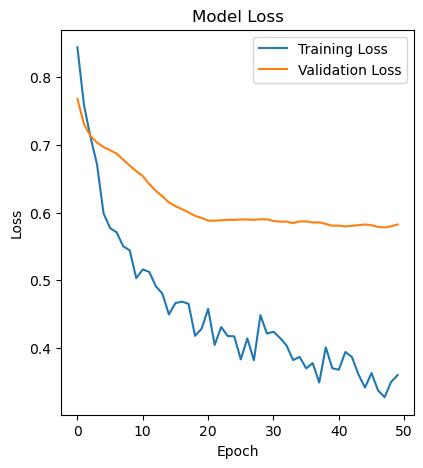

In [78]:
import matplotlib.pyplot as plt

# Assuming 'history' is from your model.fit()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plot of Model Accuracy 

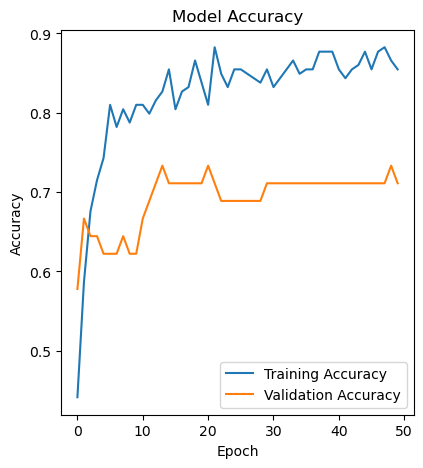

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()